- 선택 종목 알맞는 K 값 찾는 볼랜드 밴드 전략 수익률 백테스팅
- 종목 자유 선택
- 매매 방식 
  + 매도 : 상단 돌파, 매수 : 하단 돌파, 나머진 보유
- 전략 적용과 단순 보유 수익 차이

In [160]:
import pandas as pd


In [161]:
from pykrx import stock
# stock_df = stock.get_market_ohlcv_by_date('20000101','20191231','035420') # 네이버
stock_df = stock.get_market_ohlcv_by_date('20210630','20221030','035420') # 네이버
stock_df_close = stock_df[['종가']]
stock_df_close.head()

,종가
날짜,
2021-06-30,417500
2021-07-01,413000
2021-07-02,414000
2021-07-05,410000
2021-07-06,409500


In [162]:
stock_df_close['중심선'] = stock_df_close['종가'].rolling(window=14).mean()

/tmp/ipykernel_31568/1920385813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df_close['중심선'] = stock_df_close['종가'].rolling(window=14).mean()


In [163]:
stock_df_close[19:25]

,종가,중심선
날짜,,
2021-07-27,452000,438785.714286
2021-07-28,442000,440214.285714
2021-07-29,439500,441928.571429
2021-07-30,433500,443000.000000
2021-08-02,433500,442464.285714
2021-08-03,428000,441321.428571


In [164]:
K = 2
std_deviation = stock_df_close['종가'].rolling(window=14).std()
stock_df_close['상단선'] = stock_df_close['중심선'] + K * std_deviation
stock_df_close['하단선'] = stock_df_close['중심선'] - K * std_deviation



/tmp/ipykernel_31568/930140954.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df_close['상단선'] = stock_df_close['중심선'] + K * std_deviation
/tmp/ipykernel_31568/930140954.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df_close['하단선'] = stock_df_close['중심선'] - K * std_deviation


In [165]:
def calc(closes, highs, lows):
    result = []
    current_state = False  # 초기 상태는 False
    
    for close, high, low in zip(closes, highs, lows):
        if current_state:  # True 상태일 때
            if close >= high:  # 70 이상이면 False로 전환
                current_state = False
        else:  # False 상태일 때
            if close <= low:  # 30 이하면 True로 전환
                current_state = True
        
        result.append(current_state)
    
    return result

In [166]:
stock_df_close['bool'] = calc(stock_df_close['종가'],stock_df_close['상단선'],stock_df_close['하단선'])
stock_df_close['bool'][:-300]

/tmp/ipykernel_31568/270683272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_df_close['bool'] = calc(stock_df_close['종가'],stock_df_close['상단선'],stock_df_close['하단선'])


날짜
2021-06-30    False
2021-07-01    False
2021-07-02    False
2021-07-05    False
2021-07-06    False
2021-07-07    False
2021-07-08    False
2021-07-09    False
2021-07-12    False
2021-07-13    False
2021-07-14    False
2021-07-15    False
2021-07-16    False
2021-07-19    False
2021-07-20    False
2021-07-21    False
2021-07-22    False
2021-07-23    False
2021-07-26    False
2021-07-27    False
2021-07-28    False
2021-07-29    False
2021-07-30    False
2021-08-02    False
2021-08-03    False
2021-08-04    False
2021-08-05    False
2021-08-06    False
Name: bool, dtype: bool

In [167]:
stock_df_close['전일종가'] = stock_df_close['종가'].shift(periods=1)

In [168]:
import numpy as np
delta_days = stock_df_close.index[-1] - stock_df_close.index[0]
year = delta_days.days / 365

stock_df_close['수익률'] = np.where(stock_df_close['bool'], stock_df_close['종가'] / stock_df_close['전일종가'], 1)
stock_df_close['누적수익률'] = stock_df_close['수익률'].cumprod()
CAGR = stock_df_close['누적수익률'].iloc[-1] ** (1/year) -1

In [169]:
CAGR

-0.49047716346754333

In [170]:
simple_rate_of_return = stock_df_close['종가'].iloc[-1] / stock_df_close['종가'].iloc[0]
simple_cum_rate_of_return = 1 * simple_rate_of_return
CAGR = ((simple_cum_rate_of_return ** (1/year))-1) * 100
CAGR

-51.412553050318735

In [171]:
stock_df_close.tail()

,종가,중심선,상단선,하단선,bool,전일종가,수익률,누적수익률
날짜,,,,,,,,
2022-10-24,164000,165607.142857,175798.984024,155415.301690,True,166000.0,0.987952,0.418420
2022-10-25,165500,164821.428571,172865.606044,156777.251099,True,164000.0,1.009146,0.422247
2022-10-26,159500,164500.000000,173030.488308,155969.511692,True,165500.0,0.963746,0.406939
2022-10-27,161000,164071.428571,172663.528188,155479.328955,True,159500.0,1.009404,0.410766
2022-10-28,160000,164071.428571,172663.528188,155479.328955,True,161000.0,0.993789,0.408215


### Chart 작성

In [172]:
import matplotlib.pyplot as plt
import matplotlib as mpl # 한글 폰트 설정 (NanumGothic) 
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

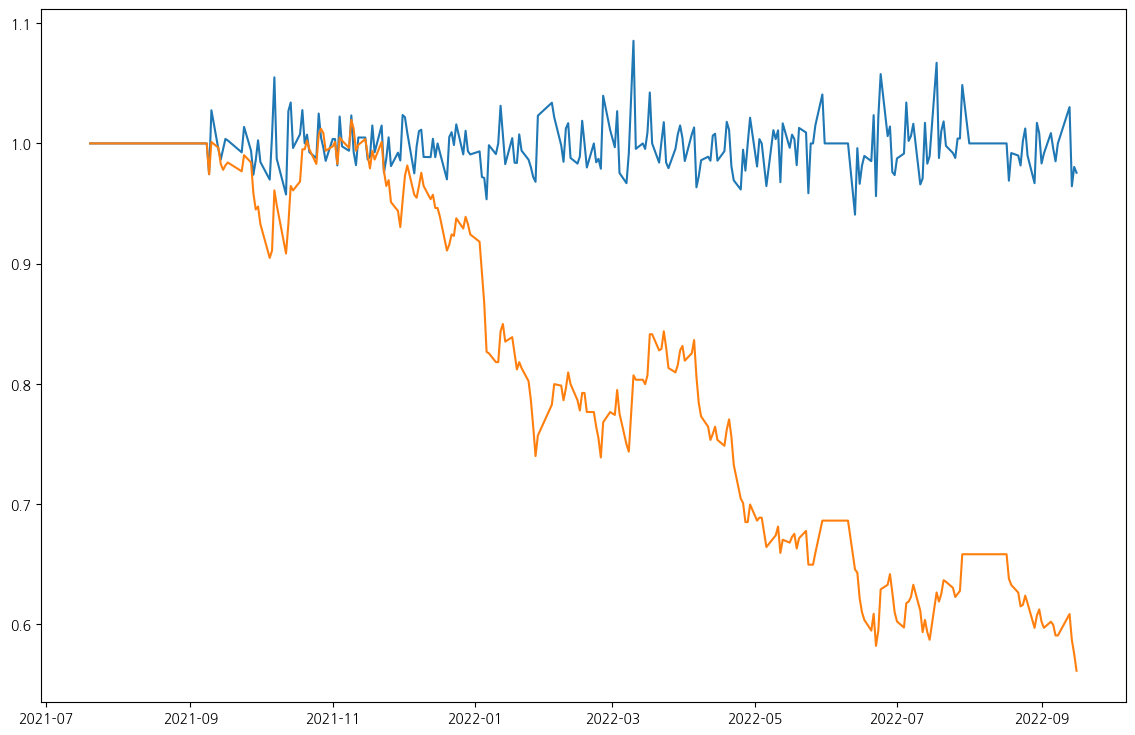

In [173]:
plt.figure(figsize=(14,9), dpi=100) #  stock_df_close['수익률']
# plt.plot(stock_df_close['종가'][14:300]/10000)
# plt.plot(stock_df_close['RSI'][14:300])
plt.plot(stock_df_close['수익률'][14:300])
plt.plot(stock_df_close['누적수익률'][14:300])
plt.show()

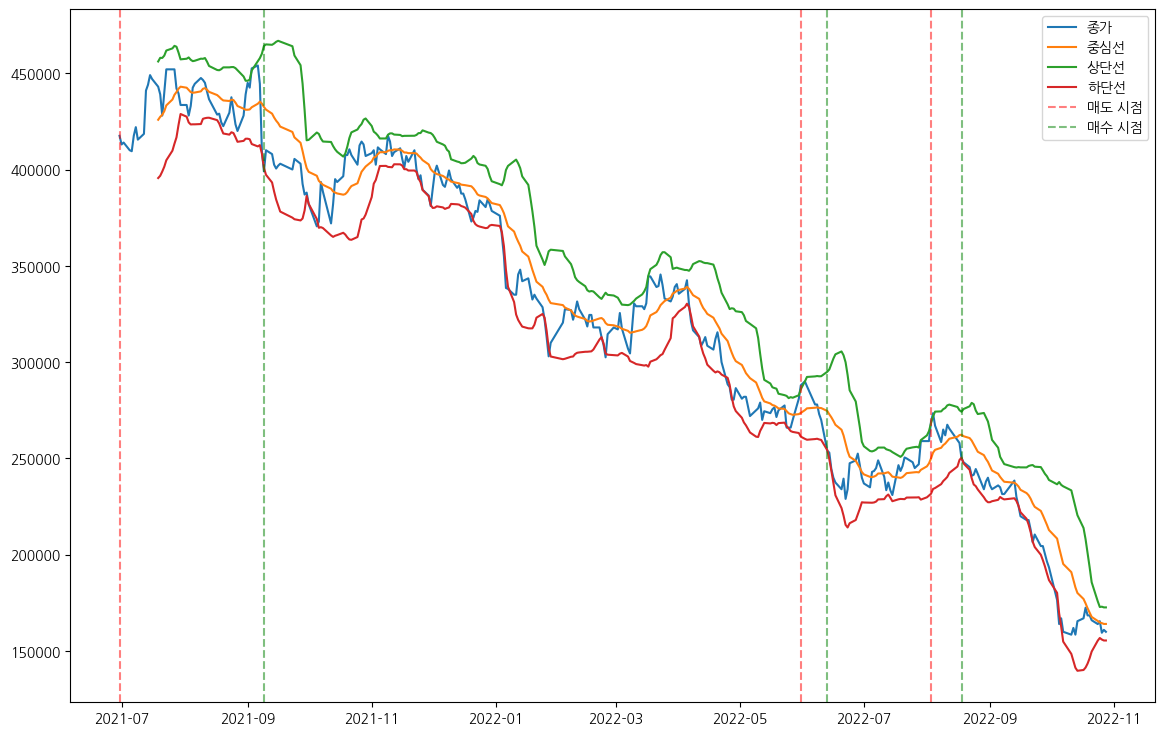

In [174]:
plt.figure(figsize=(14,9), dpi=100) # 
plt.plot(stock_df_close['종가'][:],label='종가')
plt.plot(stock_df_close['중심선'][:],label='중심선')
plt.plot(stock_df_close['상단선'][:],label='상단선')
plt.plot(stock_df_close['하단선'][:],label='하단선')
# Boolean 시리즈의 상태 변화 지점 찾기
bool_series = stock_df_close['bool'][:]
changes = bool_series.ne(bool_series.shift()).astype(int)  # 이전 값과 다른 지점 찾기
change_points = bool_series.index[changes == 1]  # 변화가 있는 지점의 인덱스

# 상태 변화 지점에 세로선 그리기
for idx in change_points:
    if bool_series[idx]:  # True로 변하는 지점
        plt.axvline(x=idx, color='g', linestyle='--', alpha=0.5, label='매수 시점' if '매수 시점' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:  # False로 변하는 지점
        plt.axvline(x=idx, color='r', linestyle='--', alpha=0.5, label='매도 시점' if '매도 시점' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.legend()
plt.show()